- A sample notebook to convert Jim Thomson's matlab structures into netcdf format
- I tried to make it as general as possible, but can't guarantee it will work for all the different structure types!
- It should be easy enough to convert this into a loop if you want to run it on lots of different files
- Author: Lettie Roach, lroach@uw.edu - last updated Apr 2020
- Edited: Vince Cooper, vcooper@uw.edu - updated Jul 2020

In [2]:
import numpy as np
import matplotlib as mpl
import glob
import os
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat,whosmat
import pandas as pd
import datetime, time
import xarray as xr

A function to convert matlab datenum to python datetime

In [3]:
def matlab2datetime(matlab_datenum):
    
    if matlab_datenum!=matlab_datenum: #if there is NaN in the time dimension
        mytime = 0 # this sets time to 1970, which we will then screen out below
    else:
        day = datetime.datetime.fromordinal(int(matlab_datenum))
        dayfrac = datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days=366)
        mytime = day + dayfrac
    return mytime

Edit these

In [22]:
datadir = './' # stored wave files in active dir
os.listdir(datadir)
fname = 'SODA_C_sigWaves.mat'

Read in SWIFT metadata

In [23]:
df = pd.read_csv('SWIFT_README.csv')
df = df.set_index('netcdf_var').transpose()
attr_dict = df.to_dict()

In [24]:
struct = loadmat(datadir+fname,squeeze_me=True)
[f for f in struct]

['__header__', '__version__', '__globals__', 'sigWaves']

Read into a pandas dataframe with python datetime format times

In [25]:
identifier = 'sigWaves' # check this makes sense with struct above, may need to edit
my_dict = struct[identifier]

In [26]:
my_dict['time'] = [matlab2datetime(tval) for tval in my_dict['time']]
my_dict['time'] = np.array(my_dict['time'],dtype='datetime64[s]')

df = pd.DataFrame(my_dict)
df = df.set_index('time')
len(df.index)

20

Any NaNs in the time index were set to 1970-01-01, so here we screen them out

In [27]:
df = df.loc[df.index > '2000-01-01']
ntime = len(df.index)
print(ntime)

20


Read in 1D (dimension=time) directly 

In [28]:
headers = [i for i in df]
headers_1d = [i for i in df if [type(j) for j in df[i]][-1] is not np.ndarray]
df_1d = df[headers_1d]
df_1d

,lat,lon,sigwaveheight,peakwaveperiod,peakwavedirT
time,,,,,
2019-07-20 22:00:00,77.7368,-139.142,0.332485,2.03983,297.008
2019-07-21 02:00:00,77.7368,-139.142,0.363045,2.25549,217.902
2019-07-21 04:00:00,77.7368,-139.142,0.341699,1.86181,NaN
2019-07-22 10:00:00,77.7368,-139.142,0.376038,2.19741,NaN
2019-07-22 16:00:00,77.7368,-139.142,0.467148,2.59897,103.559
2019-07-22 18:00:00,77.7368,-139.142,0.401306,2.25549,260.207
2019-07-23 02:00:00,77.7368,-139.142,0.416641,2.19741,NaN
2019-07-26 06:00:00,77.7368,-139.142,0.379103,1.71237,NaN
2019-08-15 02:00:00,77.7368,-139.142,0.375793,2.08978,NaN


Possible dimensions the multidimensional data could have - if it is another dimension, you will need to edit

In [29]:
test_dims = ['z','freq']

For multidimensional data, loop around and save each variable in a list of Datasets

In [242]:
headers_multd = [h for h in headers if h not in headers_1d]
list_ds = []
print(headers_multd) # e.g. 'wave_spectra' - so here there is only one set of multidimensional data

for mult in headers_multd:
    nvar = len(df[mult].values[0][()]) # number of variables below this heading e.g. 'energy','freq','a1','b1'
    ndim = len(df[mult].values[0][()][0])
    mystr = str(df[mult].values[0][()][()].dtype)
    varheaders = [var[3:-1] for var in mystr.split(',')[::2]]
    print(varheaders)
    multidimdata = np.zeros([nvar,ntime,ndim])
    for t in range(ntime):
        for v in range(nvar):
            multidimdata[v,t,:] = df[mult].values[t][()][v][:]
    
    # identify which of these variables is a dimension
    my_dim = ''
    for f in range(len(test_dims)):
        if test_dims[f] in varheaders:
            my_dim = test_dims[f]
    print(my_dim)
    
    if my_dim !='': # we found the dimension for multidimensional data
        ind_dim = varheaders.index(my_dim)
        varheaders.remove(my_dim)
        my_dim_vals = multidimdata[ind_dim,0,:]
        multidimdata = np.delete(multidimdata,ind_dim,axis=0)
        nvar = nvar - 1
    
    # make a Dataset for the first variable
    ds = xr.Dataset(
            data_vars ={mult+'_'+varheaders[0] : xr.DataArray(multidimdata[0,:,:],dims=['time',my_dim+'_'+mult])},
            coords={'time' : df.index, my_dim+'_'+mult : my_dim_vals})
    
    # if there are more variables, add these to to the Dataset
    if nvar > 1:
        for v in range(1,nvar):
            ds[mult+'_'+varheaders[v]] = xr.DataArray(multidimdata[v,:,:],dims=['time',my_dim+'_'+mult])
    list_ds.append(ds)
       
    print(ds)



['wavespectra']
['energy', 'freq', 'a1', 'b1', 'a2', 'b2', 'check']
freq
<xarray.Dataset>
Dimensions:             (freq_wavespectra: 42, time: 4036)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.4902
  * time                (time) datetime64[ns] 2018-10-09 ... 2019-09-11T22:00:00
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 nan nan ... 0.003802
    wavespectra_a1      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_b1      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_a2      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_b2      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_check   (time, freq_wavespectra) float64 nan nan nan ... nan nan


In [30]:
headers_multd = [h for h in headers if h not in headers_1d]
list_ds = []
print(headers_multd) # e.g. 'wave_spectra' - so here there is only one set of multidimensional data

for mult in headers_multd:
    nvar = len(df[mult].values[0][()]) # number of variables below this heading e.g. 'energy','freq','a1','b1'
    ndim = len(df[mult].values[0][()][0])
    mystr = str(df[mult].values[0][()][()].dtype)
    varheaders = [var[3:-1] for var in mystr.split(',')[::2]]
    print(varheaders)
    multidimdata = np.zeros([nvar,ntime,ndim])
    for t in range(ntime):
        for v in range(nvar):
            multidimdata[v,t,:] = df[mult].values[t][()][v][:]
    
    # identify which of these variables is a dimension
    my_dim = ''
    for f in range(len(test_dims)):
        if test_dims[f] in varheaders:
            my_dim = test_dims[f]
    print(my_dim)
    
    if my_dim !='': # we found the dimension for multidimensional data
        ind_dim = varheaders.index(my_dim)
        varheaders.remove(my_dim)
        my_dim_vals = multidimdata[ind_dim,0,:]
        multidimdata = np.delete(multidimdata,ind_dim,axis=0)
        nvar = nvar - 1
    
    # make a Dataset for the first variable
    ds = xr.Dataset(
            data_vars ={mult+'_'+varheaders[0] : xr.DataArray(multidimdata[0,:,:],dims=['time',my_dim+'_'+mult])},
            coords={'time' : df.index, my_dim+'_'+mult : my_dim_vals})
    
    # if there are more variables, add these to to the Dataset
    if nvar > 1:
        for v in range(1,nvar):
            ds[mult+'_'+varheaders[v]] = xr.DataArray(multidimdata[v,:,:],dims=['time',my_dim+'_'+mult])
    list_ds.append(ds)
       
    print(ds)

['wavespectra']
['energy', 'freq', 'a1', 'b1', 'a2', 'b2', 'check']
freq
<xarray.Dataset>
Dimensions:             (freq_wavespectra: 85, time: 20)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.9941
  * time                (time) datetime64[ns] 2019-07-20T22:00:00 ... 2019-09...
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 0.0 0.0 0.0 ... nan nan
    wavespectra_a1      (time, freq_wavespectra) float64 0.06227 ... -0.1196
    wavespectra_b1      (time, freq_wavespectra) float64 -0.2679 ... -0.1517
    wavespectra_a2      (time, freq_wavespectra) float64 -0.2692 ... 0.07814
    wavespectra_b2      (time, freq_wavespectra) float64 -0.2918 ... 0.142
    wavespectra_check   (time, freq_wavespectra) float64 107.8 60.35 ... 0.06249


Combine everything - 1D plus multidimensional data

In [31]:
list_ds.append(df_1d.to_xarray())
allds = xr.merge(list_ds)   

Add metadata

In [32]:
# for the whole file
allds.attrs= {'description' : identifier,
              'data' : 'SODA cruise, Sam Brenner, APL',
              'netcdf_created_by': 'Lettie Roach, 2020, UW'}

# for variables - add description and units
for var in attr_dict:
        if var in allds:
            allds[var].attrs['units'] = attr_dict[var]['units']
            allds[var].attrs['description'] = attr_dict[var]['description']

allds

<xarray.Dataset>
Dimensions:             (freq_wavespectra: 85, time: 20)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.9941
  * time                (time) datetime64[ns] 2019-07-20T22:00:00 ... 2019-09...
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 0.0 0.0 0.0 ... nan nan
    wavespectra_a1      (time, freq_wavespectra) float64 0.06227 ... -0.1196
    wavespectra_b1      (time, freq_wavespectra) float64 -0.2679 ... -0.1517
    wavespectra_a2      (time, freq_wavespectra) float64 -0.2692 ... 0.07814
    wavespectra_b2      (time, freq_wavespectra) float64 -0.2918 ... 0.142
    wavespectra_check   (time, freq_wavespectra) float64 107.8 60.35 ... 0.06249
    lat                 (time) object 77.74 77.74 77.74 ... 77.74 77.74 77.74
    lon                 (time) object -139.1 -139.1 -139.1 ... -139.1 -139.1
    sigwaveheight       (time) object 0.3325 0.363 0.3417 ... 0.3511 0.3228
    peakwaveperiod      (time) object 2.04 2.255 1.862 2.197 ... 2.04 2.04 1.679
    peakwavedirT        (time) object 297.0 217.9 nan nan ... 328.0 nan nan
Attributes:
    description:        sigWaves
    data:               SODA cruise, Sam Brenner, APL
    netcdf_created_by:  Lettie Roach, 2020, UW

Output to netcdf

In [33]:
allds.to_netcdf(fname+'_converted.nc')

In [39]:
allds

<xarray.Dataset>
Dimensions:             (freq_wavespectra: 85, time: 20)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.9941
  * time                (time) datetime64[ns] 2019-07-20T22:00:00 ... 2019-09...
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 0.0 0.0 0.0 ... nan nan
    wavespectra_a1      (time, freq_wavespectra) float64 0.06227 ... -0.1196
    wavespectra_b1      (time, freq_wavespectra) float64 -0.2679 ... -0.1517
    wavespectra_a2      (time, freq_wavespectra) float64 -0.2692 ... 0.07814
    wavespectra_b2      (time, freq_wavespectra) float64 -0.2918 ... 0.142
    wavespectra_check   (time, freq_wavespectra) float64 107.8 60.35 ... 0.06249
    lat                 (time) object 77.74 77.74 77.74 ... 77.74 77.74 77.74
    lon                 (time) object -139.1 -139.1 -139.1 ... -139.1 -139.1
    sigwaveheight       (time) object 0.3325 0.363 0.3417 ... 0.3511 0.3228
    peakwaveperiod      (time) object 2.04 2.255 1.862 2.197 ... 2.04 2.04 1.679
    peakwavedirT        (time) object 297.0 217.9 nan nan ... 328.0 nan nan
Attributes:
    description:        sigWaves
    data:               SODA cruise, Sam Brenner, APL
    netcdf_created_by:  Lettie Roach, 2020, UW

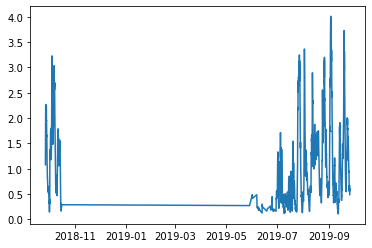

In [23]:
# SODA A
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values)

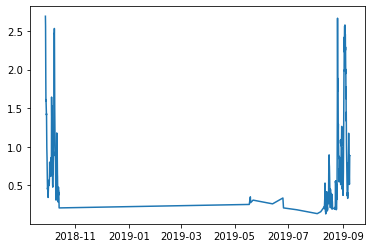

In [21]:
# SODA B
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values)

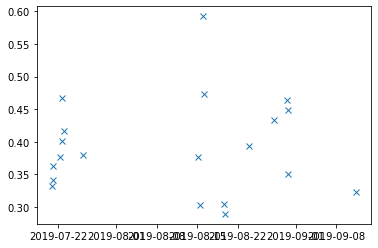

In [38]:
# SODA C
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values,marker='x',linestyle='')